In [ ]:
# !pip install plotly-resampler<=0.8.3.2
# !pip install tsdownsample==0.1.2

In [1]:
import numpy as np
import pandas as pd

import time
import timeit
from plotly_resampler.aggregation import LTTB
from tsdownsample import MinMaxLTTBDownsampler

# Create the downsamplers
lttb = LTTB()
minmaxlttb_tsd = MinMaxLTTBDownsampler()

In [2]:
## The benchmarking configs
NB_REPEATS = 7
NUMBER = 10

# MinMax-reselection ratio
minmax_ratio = 4
# Number of aggregated output points
n_out = 2_000

# The number of points in the input time series
Ns = [1_000_000, 10_000_000, 20_000_000, 50_000_000, 100_000_000, 200_000_000, 500_000_000, 1_000_000_000]
# The considered dtypes
dtypes = [np.float32]


## Perform the performance benchmarking

In [3]:
downsample_dict = {
    "LTTB [PR]": f"lttb._aggregate(s, n_out)",
    "MinMaxLTTB": f"minmaxlttb_tsd.downsample(arr, n_out=n_out, minmax_ratio=minmax_ratio)",
    "MinMaxLTTB (parallel)": f"minmaxlttb_tsd.downsample(arr, n_out=n_out, minmax_ratio=minmax_ratio, parallel=True)",
}

downsample_times = {k: {str(dtype) : [] for dtype in dtypes} for k in downsample_dict.keys() }

for N in Ns:
    for dtype in dtypes:
        arr = np.random.randn(N).astype(dtype)
        s = pd.Series(arr, dtype=dtype)
        # print memory usage
        print(f"Memory usage: {s.memory_usage(deep=True) / 1e6:.2f} MB")
        for k, v in downsample_dict.items():
            time.sleep(1)
            res = timeit.repeat(v, globals=globals(), number=NUMBER, repeat=NB_REPEATS)
            downsample_times[k][str(dtype)].append(res)

    del s
    del arr
    time.sleep(1)

Memory usage: 4.00 MB
Memory usage: 40.00 MB
Memory usage: 80.00 MB
Memory usage: 200.00 MB
Memory usage: 400.00 MB
Memory usage: 800.00 MB
Memory usage: 2000.00 MB
Memory usage: 4000.00 MB


In [4]:
# pickle the downsample_times dict
import pickle

pickle.dump(downsample_times, open("downsample_times.pkl", "wb"))

LTTB [PR] <class 'numpy.float32'> 3.2360220445626937e-06
MinMaxLTTB <class 'numpy.float32'> 3.323794389601907e-07
MinMaxLTTB (parallel) <class 'numpy.float32'> 9.273054992335958e-08


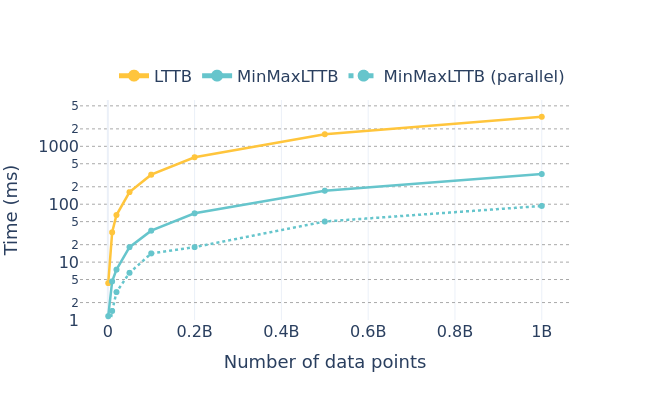

In [6]:
# visualize
import plotly.graph_objects as go
import plotly.express as px

color_dict = {
    "LTTB [PR]": "#ffc53c",
    "MinMax": px.colors.qualitative.Pastel[1],
    "MinMaxLTTB": px.colors.qualitative.Pastel[0],
    "MinMaxLTTB (parallel)": px.colors.qualitative.Pastel[0],
}


fig = go.Figure()
for k, v in downsample_times.items():
    if k == "EveryNth":
        continue
    for dtype in dtypes:
        if not "float32" in str(dtype):
            continue
        v_ = np.array(v[str(dtype)]) * 1e3 / NUMBER # convert to ms
        v_ = np.min(v_, axis=1)  # calculate the mean
        # calculate the slope of the line
        print(k, dtype, np.polyfit(Ns, v_, 1)[0])
        name = k.replace(" [PR]", "")
        # dashed line if parallel
        fig.add_trace(go.Scatter(x=Ns, y=v_, name=name, line=dict(width=2.5, color=color_dict[k], dash="dot" if "parallel" in k else "solid")))
fig.update_layout(
    # title="Time to aggregate",
    xaxis_title="Number of data points",
    yaxis_title="Time (ms)",
    # legend_title="Aggregation method",
    width=650,
    height=400,
    template="plotly_white",
    legend=dict(
            title_text="",
            orientation="h",
            yanchor="bottom",
            itemsizing="constant",
            y=1.03,
            xanchor="right",
            x=1,
            font_size=16.5,
        ),
)
# update font size of axes
fig.update_yaxes(tickfont=dict(size=16), title_font=dict(size=18))
fig.update_xaxes(tickfont=dict(size=16), title_font=dict(size=18))
# log scale
fig.update_yaxes(type="log", range=[0, 3.8], gridcolor="darkgrey", griddash="dot")

fig.show(renderer="png")